<b> <font size="+2.5"> Create gene expression plotting object
 </b> </font> <br>

<b> major cell types </b>

Date: 2023-12-27 <br>
Author: ASF

# Load libraries

In [1]:
### Set up
suppressPackageStartupMessages({
library(dplyr)
library(stringr)
library(ggplot2)
library(tidyverse)
library(readxl)
library(edgeR)
library(ggpubr)
library(cowplot)
})

# Read in meta data

In [2]:
meta_data <- as.data.frame(read.delim("../datasets/adata.obs_20231120.tsv", sep='\t'))

In [3]:
#select columns of interest
meta_data_subset <- meta_data[c("sample","individual","Age", "Sex", "Status", "RIN", "Brain.pH", "PMI", 
                                "X6.Batch")]

#keep only unique observations (one line per individual)
meta_data_subset <- meta_data_subset %>% distinct(individual, .keep_all=TRUE)

meta_data_subset$Status <- as.character(meta_data_subset$Status)
meta_data_subset$Disease_Status <- ifelse(meta_data_subset$Status=='0', 'Controls', 'Cases')
meta_data_subset$Disease_Status <- factor(meta_data_subset$Disease_Status, levels=c('Controls', 'Cases'))

dim(meta_data_subset)
#head(meta_data_subset)

[1] 87 10

In [4]:
# Set missing RIN to median
meta_data_subset$RIN[is.na(meta_data_subset$RIN)] <- median(meta_data_subset$RIN, na.rm=TRUE) 

#change column names
colnames(meta_data_subset)[which(names(meta_data_subset) == 'Brain.pH')] <- 'pH'
colnames(meta_data_subset)[which(names(meta_data_subset) == 'X6.Batch')] <- 'lib_batch'
meta_data_subset$lib_batch <- as.character(meta_data_subset$lib_batch)

# order by individual identifier (descending)
meta_data_subset <- meta_data_subset[order(meta_data_subset$individual),]
#head(meta_data_subset)

In [5]:
# read in PC1_hidden_noise
PC1 <- read_xlsx(path = "../datasets/PC1_hidden_confounders.xlsx")
#this table needs to be in the same order (individual)
# check: 
unique(meta_data_subset$individual == PC1$individual)

meta_data_subset <- merge(meta_data_subset, PC1, by='individual')
colnames(meta_data_subset)[which(names(meta_data_subset) == 'PC1_hidden_noise')] <- 'PC1'

[1] TRUE

# Read in pseudocount matrices from major cell types

see folder 04; script 01b_make_pseudobulk_major_celltypes.ipynb to obtain pseudobulk counts

In [6]:
# make a list of all the file names you want to read in 
files <- list.files(path="../datasets/PseudoBulkFinal/major_celltypes", pattern="^.[^L].*matrix.tsv$", full.names=T)

#read in all count matrices of all cell types and put in a list object
#make temporary object (tmp) to assign the rownames with individual and remove 
#first and second column that is not count data and transpose using t
counts_list=lapply(files, function(x) { 
  tmp=base::as.data.frame(read.delim(x, sep='\t', head=T))
  rownames(tmp)=tmp[,2] 
  return( base::as.data.frame(t( tmp[,-c(1:2)])) )
} 
)

#assign the names of the cell types to the corresponding list in the object counts list
names(counts_list)=gsub(files, pattern="^.*PseudoBulkFinal/major_celltypes.|_pseudobulk.*$", replacement="")

summary(counts_list)

## filter genes

<b>  <font size="+2.5">  60 % </b>

In [ ]:
########## FILTER genes 
#counts >10 and expressed in >60% individuals

celltypes <- names(counts_list)

counts_10_60 <- list()
for (i in celltypes){
  tmp <- counts_list[[i]]
  tmp2 <- tmp[rowSums(tmp > 10) > (0.6*dim(tmp)[2]),] # filter based on 60% of specific cell type
  counts_10_60[[i]] <- tmp2 
}

#save  filtered counts
save(counts_10_60, file = "../datasets/counts_major_celltypes_10_60.RData")

In [ ]:
# count how many genes are left after applying counts filter
n_genes_tested <- as.data.frame(matrix(ncol=3, nrow = 0))
for (i in celltypes){
  tmp <- counts_10_60[[i]]
  n_genes <- as.data.frame(t(c(i, dim(tmp)[1], dim(tmp)[2])))
  n_genes_tested <- rbind(n_genes_tested, n_genes)
}
colnames(n_genes_tested) <- c('celltype', 'n_genes','n_individuals')
n_genes_tested$n_genes <- as.numeric(n_genes_tested$n_genes)
n_genes_tested$n_individuals <- as.numeric(n_genes_tested$n_individuals)
n_genes_tested <- n_genes_tested[order(-n_genes_tested$n_genes),] # order descending
head(n_genes_tested)

In [ ]:
# min.count=10, min.prop=0.8, min.cells=5, min.samples=61
# minimum number of observed cells for a sample to be included in the analysis: this should barely change anything
# minimum numberof reads for a gene to be considered expressed in a sample. PassedtoedgeR::filterByExpr 
# min.samples minimum number of samples passing cutoffs for cell cluster to be retained

# Normalization

In [ ]:
########## CREATE DGEList OBJECT and calculate NORMFACTORS
DGE_list <- list()
for (celltype in names(counts_10_60)){
  tmp <- counts_10_60[[celltype]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <- meta_data_subset[!meta_data_subset$individual %in%  missing,]
  DGE_object <- DGEList(tmp, samples = meta_data_updated) #make DGE object
  DGE_object <- calcNormFactors(DGE_object) # calculate normfactors
  DGE_list[[celltype]] <- DGE_object } else {
    DGE_object <- DGEList(tmp, samples = meta_data_subset) #make DGE object
    DGE_object <- calcNormFactors(DGE_object) # calculate normfactors
    DGE_list[[celltype]] <- DGE_object }
}

In [ ]:
########## VOOM TRANSFORMATION
#define model
des <- "~ Disease_Status + Sex + Age + pH + RIN + PMI + lib_batch + PC1"
# specify model to fitted
mm <- model.matrix(as.formula(des), data = meta_data_subset)

# WHAT DOES VOOM DO?
# If counts is a DGEList object from the edgeR package, then voom will use the normalization factors found in the object when computing the logCPM values. In other words, the logCPM values are computed from the effective library sizes rather than the raw library sizes.
# A linear model is fitted to the log2 CPM for each gene, and the residuals are calculated
#A smoothed curve is fitted to the sqrt(residual standard deviation) by average expression (see red line in plot above)
#The smoothed curve is used to obtain weights for each gene and sample that are passed into limma along with the log2 CPMs.

voom_counts_10_60 <- list()
for (celltype in names(DGE_list)){
  tmp <- DGE_list[[celltype]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <-meta_data_subset[!meta_data_subset$individual %in%  missing,]
    mm_updated <- model.matrix(as.formula(des), data = meta_data_updated)
    voom_counts_10_60[[celltype]] <- voom(tmp, mm_updated, plot = F)} 
  else{
    voom_counts_10_60[[celltype]] <- voom(tmp, mm, plot = F)}
}


# Remove batch effects

In [ ]:
########## REMOVE BATCH EFFECTS

# Define own method that is able to remove 3 categorical batch variables
# written by Nathalie Gerstner
remove3BatchEffects <- function(x,batch=NULL,batch2=NULL,batch3=NULL,
                                covariates=NULL,design=matrix(1,ncol(x),1),...)
  #  Remove batch effects from matrix of expression data
  #  Adapted from Gordon Smyth and Carolyn de Graaf
  #  Created 1 Aug 2008. Last revised 1 June 2014.
{
  if(is.null(batch) && is.null(batch2) && is.null(batch3) && is.null(covariates)) return(as.matrix(x))
  if(!is.null(batch)) {
    batch <- as.factor(batch)
    contrasts(batch) <- contr.sum(levels(batch))
    batch <- model.matrix(~batch)[,-1,drop=FALSE]
  }
  if(!is.null(batch2)) {
    batch2 <- as.factor(batch2)
    contrasts(batch2) <- contr.sum(levels(batch2))
    batch2 <- model.matrix(~batch2)[,-1,drop=FALSE]
  }
  if(!is.null(batch3)) {
    batch3 <- as.factor(batch3)
    contrasts(batch3) <- contr.sum(levels(batch3))
    batch3 <- model.matrix(~batch3)[,-1,drop=FALSE]
  }
  if(!is.null(covariates)) covariates <- as.matrix(covariates)
  X.batch <- cbind(batch,batch2,batch3,covariates)
  fit <- lmFit(x,cbind(design,X.batch),...)
  beta <- fit$coefficients[,-(1:ncol(design)),drop=FALSE]
  beta[is.na(beta)] <- 0
  as.matrix(x) - beta %*% t(X.batch)
}

In [ ]:
#use the remove3BatchEffects() adapted by Nathalie 
# removeBatchEffects() expects numeric matrix with log-expression values
# matrix with rows corresponding to genes and columns corresponding to samples
counts_batches_removed <- list()
for (i in celltypes){
  tmp <- voom_counts_10_60[[i]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <-meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- remove3BatchEffects(tmp, batch = meta_data_updated$Disease_Status, batch2 = meta_data_updated$Sex, 
                                batch3 = meta_data_updated$lib_batch,
                                covariates = meta_data_updated[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed[[i]] <- tmp2
  } else {
    tmp2 <- remove3BatchEffects(tmp, batch = meta_data_subset$Disease_Status, batch2 = meta_data_subset$Sex,
                                batch3 = meta_data_subset$lib_batch,
                                covariates = meta_data_subset[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed[[i]] <- tmp2
  }}

save(counts_batches_removed, file = "../plotting_objects/plotting_object_batch_corrected_MJ.RData")

In [ ]:
##### remove all batches except Age and Status 
#(for genes influenced by both age and disease status)
#use standard removeBatchEffect() from limma
counts_batches_removed_Age_Status <- list()
for (i in celltypes){
  tmp <- voom_counts_10_60[[i]]
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <-meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- removeBatchEffect(tmp, batch = meta_data_updated$lib_batch, batch2 = meta_data_updated$Sex,
                                covariates = meta_data_updated[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed_Age_Status[[i]] <- tmp2
  } else {
    tmp2 <- removeBatchEffect(tmp, batch = meta_data_subset$lib_batch, batch2 = meta_data_subset$Sex,
                                covariates = meta_data_subset[,c("pH", "PMI", "RIN", "PC1")])
    counts_batches_removed_Age_Status[[i]] <- tmp2
  }}

save(counts_batches_removed_Age_Status, file = "../plotting_objects/plotting_object_corrected_NOT_age_status_MJ.RData")

In [ ]:
head(counts_batches_removed_Age_Status[['Astrocytes']])

# Plot genes of interest

In [6]:
load('../plotting_objects/plotting_object_batch_corrected_MJ.RData')

In [7]:
# read in the gene information to obtain gene name (ID) and ensembl ID
var <- read.delim("../datasets/adata.var_20231120.tsv", sep='\t')

#select gene ID and ensembl ID
gene_names_ensembl <- var %>% select('X', 'gene_ids')
gene_names_ensembl <- as.data.frame(gene_names_ensembl)
colnames(gene_names_ensembl) <- c('ID', 'ensembl')
head(gene_names_ensembl)

,ID,ensembl
,<chr>,<chr>
1,AL627309.1,ENSG00000238009
2,AL627309.5,ENSG00000241860
3,LINC01409,ENSG00000237491
4,LINC01128,ENSG00000228794
5,LINC00115,ENSG00000225880
6,FAM41C,ENSG00000230368


In [8]:
# Age effect
# genes at FDR < 0.1

celltypes <- c('Astrocytes', 'Endothelial', 'Exc_Neurons', 'In_Neurons', 'Microglia', 'Oligodendrocyte', 'OPC')

DE_genes_Age <- list()
for (celltype in celltypes){
    tmp <- as.data.frame(read_excel('../results/dreamlet_tables/final_celltypes_N87/DE_results_Age_major_celltypes_20231123.xlsx', sheet = celltype))
    tmp <- tmp[tmp$adj.P.Val < 0.1,]
    #merge gene ID and ensembl ID
    DE_genes_Age[[celltype]] <- merge(tmp, gene_names_ensembl, by='ID')
}

In [9]:
# add meta_data to gene counts
counts_w_meta_data <- list()
for (celltype in celltypes){
  tmp <- data.frame(t(counts_batches_removed[[celltype]]))
  tmp$individual <- rownames(tmp)
  if (dim(tmp)[2] < 87){
    missing <- setdiff(meta_data_subset$individual, colnames(tmp))
    meta_data_updated <- meta_data_subset[!meta_data_subset$individual %in%  missing,]
    tmp2 <- merge(tmp, meta_data_updated, by='individual')
    DE_Age_counts_w_meta_data[[celltype]] <- tmp2 }
  tmp2 <- merge(tmp, meta_data_subset, by='individual')
  counts_w_meta_data[[celltype]] <- tmp2
}

In [10]:
##### IMPORTANT -> cell types have to be in alphabetical order - otherwise the automatic colouring will not work in the plotting function below
celltype_colours <- c('#ddc9b4', '#6e4c3c', '#2B3A67', '#e26d5c', '#7A6C5D', '#FFE1A8', '#FFC482')

names(celltype_colours) <- c('Astrocytes','Endothelial','Exc_Neurons','In_Neurons',
                             'Microglia','Oligodendrocyte','OPC')

## Fig. 2c - NRGN - shared across all major cell types

[1] "ENSG00000154146"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


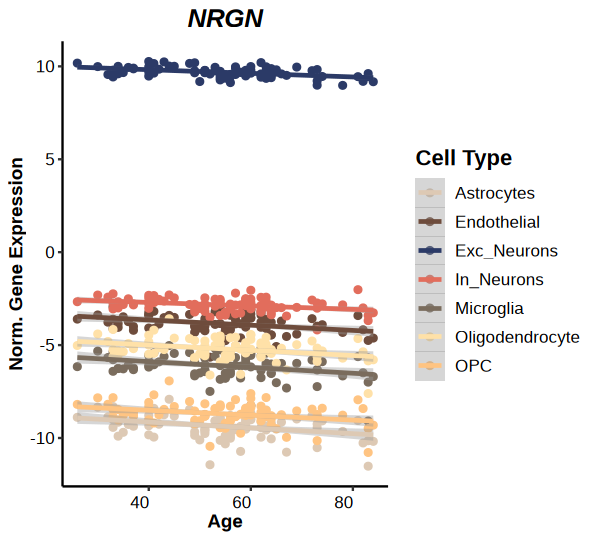

In [11]:
### Plot NRGN
# the only genes DE at FDR < 0.05 in all major cell types

# NRGN
NRGN_ensembl <- DE_genes_Age[['Exc_Neurons']]$ensembl[which(DE_genes_Age[['Exc_Neurons']]$ID=='NRGN')]

NRGN <- as.data.frame(matrix(ncol=4, nrow=0))
colnames(NRGN) <- c('individual', 'Age', NRGN_ensembl, 'celltype')
for (celltype in names(DE_genes_Age)) {
  tmp <- counts_w_meta_data[[celltype]]
  if (NRGN_ensembl %in% colnames(tmp)){
    temp <- tmp %>% dplyr::select(all_of(c('individual', 'Age', NRGN_ensembl)))
    temp$celltype <- celltype
    NRGN <- rbind(NRGN, temp)}
  else {next}
}

colours_f_plot <- celltype_colours[names(celltype_colours) %in% c(unique(NRGN$celltype))]

#print ensembl_id and manually insert
NRGN_ensembl 

options(repr.plot.width=5, repr.plot.height=4.5)
NRGN %>%
  ggplot(aes(x= Age,ENSG00000154146)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('NRGN')+ scale_color_manual(name = "Cell Type",values=colours_f_plot)

ggsave('../figures/NRGN_expr_major_celltypes.pdf', plot=last_plot(), width=4, height=4)

## Fig. 6c - genes congruent btw Age and AD

[1] "ENSG00000089169"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


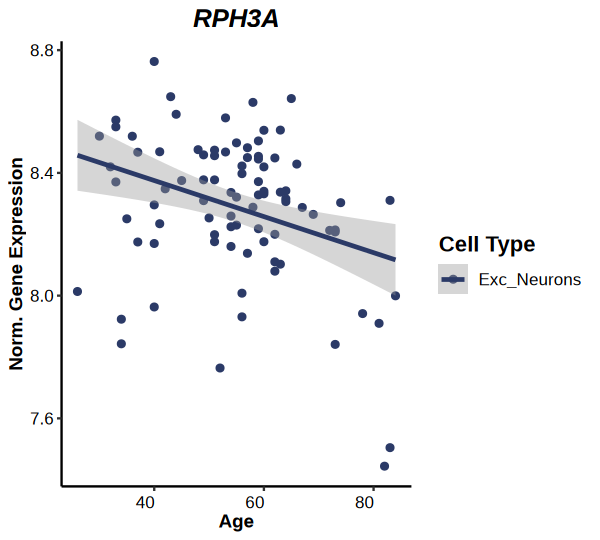

In [11]:
RPH3A_ensembl <- DE_genes_Age[['Exc_Neurons']]$ensembl[which(DE_genes_Age[['Exc_Neurons']]$ID=='RPH3A')]
RPH3A_ensembl

RPH3A <- counts_w_meta_data[['Exc_Neurons']] %>% dplyr::select(all_of(c('individual', 'Age', 'Status', RPH3A_ensembl)))
RPH3A$celltype <- 'Exc_Neurons'

options(repr.plot.width=5, repr.plot.height=4.5)
RPH3A %>%
  ggplot(aes(x= Age,ENSG00000089169)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('RPH3A')+ scale_color_manual(name = "Cell Type",values=celltype_colours['Exc_Neurons']) 

ggsave('../figures/RPH3A_expr_Exc_Neurons.pdf', plot = last_plot(), width = 3.5, height =3.5)

[1] "ENSG00000198822"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


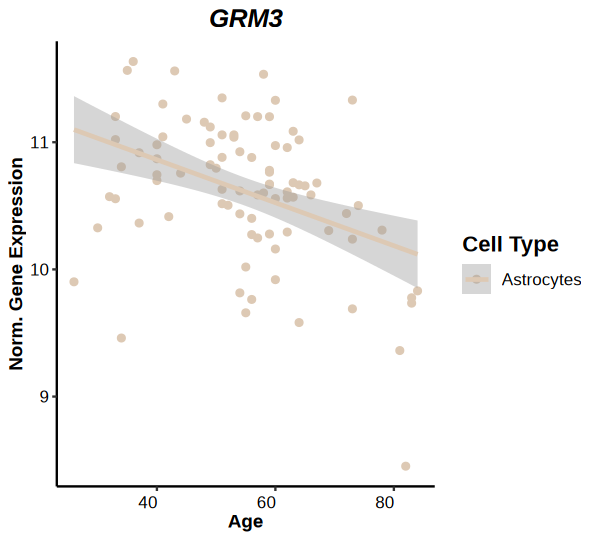

In [12]:
GRM3_ensembl <- DE_genes_Age[['Astrocytes']]$ensembl[which(DE_genes_Age[['Astrocytes']]$ID=='GRM3')]
GRM3_ensembl

GRM3 <- counts_w_meta_data[['Astrocytes']] %>% dplyr::select(all_of(c('individual', 'Age', 'Status', GRM3_ensembl)))
GRM3$celltype <- 'Astrocytes'

options(repr.plot.width=5, repr.plot.height=4.5)
GRM3 %>%
  ggplot(aes(x= Age,ENSG00000198822)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('GRM3')+ scale_color_manual(name = "Cell Type",values=celltype_colours['Astrocytes']) 

ggsave('../figures/GRM3_expr_Astrocytes.pdf', plot = last_plot(), width = 3.5, height =3.5)

## Fig. 6e - genes opposite btw Age and AD

[1] "ENSG00000169783"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


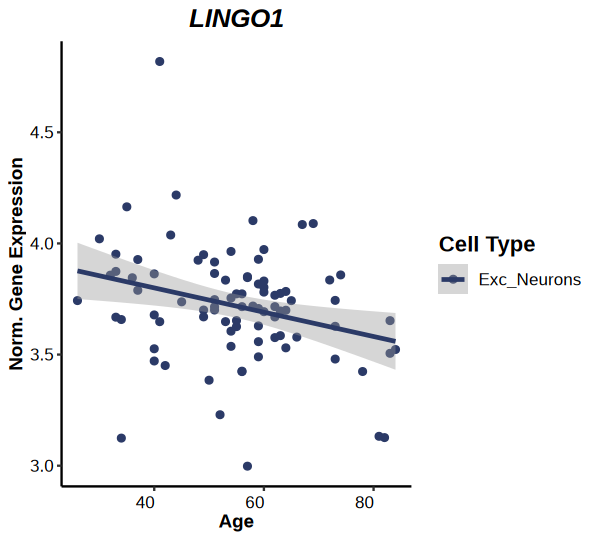

In [13]:
LINGO1_ensembl <- DE_genes_Age[['Exc_Neurons']]$ensembl[which(DE_genes_Age[['Exc_Neurons']]$ID=='LINGO1')]
LINGO1_ensembl

LINGO1 <- counts_w_meta_data[['Exc_Neurons']] %>% dplyr::select(all_of(c('individual', 'Age', 'Status', LINGO1_ensembl)))
LINGO1$celltype <- 'Exc_Neurons'

options(repr.plot.width=5, repr.plot.height=4.5)
LINGO1 %>%
  ggplot(aes(x= Age,ENSG00000169783)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('LINGO1')+ scale_color_manual(name = "Cell Type",values=celltype_colours['Exc_Neurons']) 

ggsave('../figures/LINGO1_expr_Exc_Neurons.pdf', plot = last_plot(), width = 3.5, height =3.5)

[1] "ENSG00000100379"

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


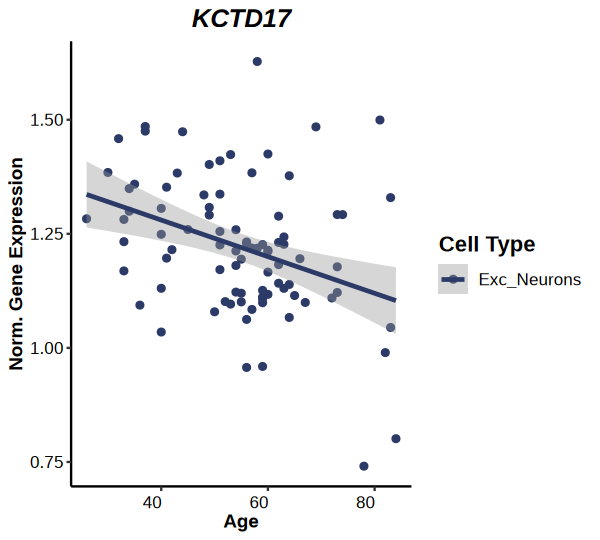

In [14]:
KCTD17_ensembl <- DE_genes_Age[['Exc_Neurons']]$ensembl[which(DE_genes_Age[['Exc_Neurons']]$ID=='KCTD17')]
KCTD17_ensembl

KCTD17 <- counts_w_meta_data[['Exc_Neurons']] %>% dplyr::select(all_of(c('individual', 'Age', 'Status', KCTD17_ensembl)))
KCTD17$celltype <- 'Exc_Neurons'

options(repr.plot.width=5, repr.plot.height=4.5)
KCTD17 %>%
  ggplot(aes(x= Age,ENSG00000100379)) +
  geom_point(aes(color=celltype), size=1.5) + theme_classic() + 
  geom_smooth(aes(group=celltype, color=celltype), method = "lm") + 
  theme(axis.text=element_text(size=10, colour='black'),axis.title=element_text(size=11,face="bold"), axis.text.x = element_text(angle = 0, vjust = 0.5, hjust=1)) + 
  theme(legend.text = element_text(size=10)) + theme(legend.title=element_text(size=13, face='bold'))+
  theme(plot.title = element_text(size=15, hjust = 0.5, face='bold.italic'))+
  labs(y= "Norm. Gene Expression", x = "Age") +
  ggtitle('KCTD17')+ scale_color_manual(name = "Cell Type",values=celltype_colours['Exc_Neurons']) 

ggsave('../figures/KCTD17_expr_Exc_Neurons.pdf', plot = last_plot(), width = 3.5, height =3.5)

# Session Info

In [15]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /psycl/u/afroe/conda-envs/dreamlet_duplicated/lib/libopenblasp-r0.3.24.so;  LAPACK version 3.11.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

time zone: Europe/Berlin
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] cowplot_1.1.1   ggpubr_0.6.0    edgeR_4.0.1     limma_3.58.1   
 [5] readxl_1.4.3    lubridate_1.9.3 forcats_1.0.0   purrr_1.0.2    
 [9] readr_2.1.4     tidyr_1.3.0     tibble_3.2.1    tidyverse_2.0.0
[13]